# Train U-Net for cervix/os detection

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from datetime import datetime
    
# Project
project_common_path = os.path.abspath(os.path.join('..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [3]:
import matplotlib.pylab as plt
%matplotlib inline

def plt_st(n, m):
    plt.figure(figsize=(n, m))

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Transform `sloth` annotations to label images

In [4]:
from data_utils import type_1_ids, type_2_ids, type_3_ids, test_ids
from data_utils import RESOURCES_PATH, GENERATED_DATA, get_annotations

from image_utils import get_image_data
from image_utils import generate_label_images

In [5]:
sloth_annotations_filename = os.path.join(RESOURCES_PATH, 'cervix_os.json')
annotations = get_annotations(sloth_annotations_filename)
print(len(annotations))

#generate_label_images(annotations)

1303


In [6]:
!ls {GENERATED_DATA}/
ret = !ls {GENERATED_DATA}/trainval_labels_0 | wc -l
print(ret[0])

assert len(annotations) == int(ret[0]), "WTF"

cervix_train_stats.npz
check_cervix_stats.npz
check_os_stats.npz
os_cervix_labels_1
os_cervix_labels_2
os_cervix_labels_final
resnet_4_dense_adadelta_seed=2017_stats.npz
resnet_4_dense_cervix_adadelta_seed=2017_stats.npz
resnet_4_dense_cervix_nadam_seed=2017_stats.npz
resnet_4_dense_nadam_seed=2017_stats.npz
resnet_4_dense_seed=2017_stats.npz
resnet_not_trained_original_cervix_adadelta_seed=2017_stats.npz
resnet_not_trained_original_norm_cervix_adadelta_seed=2017_stats.npz
resnet_original_cervix_seed=2017_stats.npz
templates.csv
test
train
trainval_labels_0
unet_os_cervix_detector_opt=adadelta_seed=54321_lr=1.000_a=0.975_stats.npz
unet_os_cervix_detector_seed=2017_lr=0.001_a=0.925_stats.npz
xception_trained_3_dense_norm_cervix_adadelta_seed=2017_stats.npz
xception_trained_3_dense_norm_os_adadelta_seed=2017_stats.npz
xception_trained_norm_os_adadelta_seed=2017_stats.npz
xception_trained_original_cervix_adadelta_seed=2017_stats.npz
xception_trained_original_norm_cervix_adadelta_seed=2017

## Train and validate

In [7]:
import numpy as np

from training_utils import get_trainval_id_type_lists2
from test_utils import get_test_id_type_list2

from unet_keras_v1 import get_unet

from training_utils import segmentation_train as train, segmentation_validate as validate
from test_utils import segmentation_predict as predict
from xy_providers import DataCache

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5110)


In [8]:
print("\n {} - Get U-Net model ...".format(datetime.now()))
optimizer = 'adadelta'
unet = get_unet(input_shape=(3, 224, 224), n_classes=2, optimizer=optimizer)


 2017-04-15 16:12:13.750688 - Get U-Net model ...


In [9]:
unet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 224, 224)  896         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 32, 224, 224)  128         convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 224, 224)  0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

Load trained weights

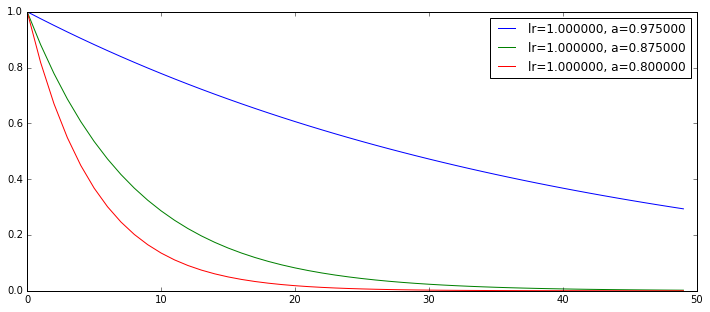

In [9]:
from training_utils import exp_decay

lr_base = 1.0
lr_1 = 1 * lr_base; a_1 = 0.975
lr_2 = 1 * lr_base; a_2 = 0.875
lr_3 = 1 * lr_base; a_3 = 0.8

epochs = np.arange(0, 50)
lrs_1 = exp_decay(epochs, lr=lr_1, a=a_1)
lrs_2 = exp_decay(epochs, lr=lr_2, a=a_2)
lrs_3 = exp_decay(epochs, lr=lr_3, a=a_3)
plt_st(12, 5)
plt.plot(epochs, lrs_1, label="lr=%f, a=%f" % (lr_1, a_1))
plt.plot(epochs, lrs_2, label="lr=%f, a=%f" % (lr_2, a_2))
plt.plot(epochs, lrs_3, label="lr=%f, a=%f" % (lr_3, a_3))
plt.legend()

In [10]:
seed = 54321
np.random.seed(seed)
save_prefix='unet_os_cervix_detector_opt=%s_seed=%i_lr=%.3f_a=%.3f' % (optimizer, seed, lr_1, a_1)

In [11]:
train_id_type_list, val_id_type_list = get_trainval_id_type_lists2(annotations=annotations, val_split=0.215)

print "Total : %s, Train : %s, Val : %s" % (len(annotations), len(train_id_type_list), len(val_id_type_list))

Total : 1303, Train : 1022, Val : 281


In [12]:
from glob import glob
from training_utils import find_best_weights_file

weights_files = glob("weights/%s*.h5" % save_prefix)
best_weights_filename, best_val_loss = find_best_weights_file(weights_files)
print("Best val loss weights: ", best_weights_filename)

if len(best_weights_filename) > 0:
    # load weights to the model
    print("Load found weights: ", best_weights_filename)
    unet.load_weights(best_weights_filename)

('Best val loss weights: ', '')


In [13]:
# Define only once
try:
    if cache is None: 
        cache = DataCache(0)    
except NameError:
    cache = DataCache(0)        

In [14]:
if True:
        
    nb_epochs = 50
    batch_size = 4
    
    #lr_1 = 1e-5; a_1 = 0.985
    lrate_decay_f = lambda epoch: exp_decay(epoch, lr=lr_1, a=a_1) 

    print("\n {} - Start training ...".format(datetime.now()))
    h = train(unet, 
              train_id_type_list, 
              val_id_type_list, 
              nb_epochs=nb_epochs,
              samples_per_epoch=1024,
              nb_val_samples=512,
              lrate_decay_f=lrate_decay_f,
              batch_size=batch_size, 
              xy_provider_cache=cache,
              seed=seed,
              save_prefix=save_prefix)


 2017-04-15 16:12:15.081427 - Start training ...

-- Training parameters: 4, 50, 1024, 512

-- Fit stats of train dataset
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/unet_os_cervix_detector_opt=adadelta_seed=54321_lr=1.000_a=0.975_stats.npz
No need to recompute statistics

-- Fit model
Epoch 1/50
1024/1024 [==============================] - 933s - loss: 0.7118 - jaccard_index: 0.2882 - recall: 0.8336 - precision: 0.4383 - val_loss: 0.6501 - val_jaccard_index: 0.3499 - val_recall: 0.8802 - val_precision: 0.5309
Epoch 2/50
1024/1024 [==============================] - 839s - loss: 0.6712 - jaccard_index: 0.3288 - recall: 0.7898 - precision: 0.5374 - val_loss: 0.5970 - val_jaccard_index: 0.4030 - val_recall: 0.8304 - val_precision: 0.6203
Epoch 3/50
1024/1024 [==============================] - 839s - loss: 0.6428 - jaccard_index: 0.3572 - recall: 0.7870 - precision: 0.5992 - val_loss: 0.5644 - val_jaccard_index: 0.4356 - val_recall: 0.8253 - val_p

KeyError: 'val_jaccard_index'

In [15]:
if True:
        
    nb_epochs = 20
    batch_size = 4
    
    lr_1 = 0.4; a_1 = 0.985
    lrate_decay_f = lambda epoch: exp_decay(epoch, lr=lr_1, a=a_1) 

    print("\n {} - Start training ...".format(datetime.now()))
    h = train(unet, 
              train_id_type_list, 
              val_id_type_list, 
              nb_epochs=nb_epochs,
              samples_per_epoch=1024,
              nb_val_samples=512,
              lrate_decay_f=lrate_decay_f,
              batch_size=batch_size, 
              xy_provider_cache=cache,
              seed=seed,
              save_prefix=save_prefix)


 2017-04-16 09:23:00.294463 - Start training ...

-- Training parameters: 4, 20, 1024, 512

-- Fit stats of train dataset
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/unet_os_cervix_detector_opt=adadelta_seed=54321_lr=1.000_a=0.975_stats.npz
No need to recompute statistics

-- Fit model
Epoch 1/20
1024/1024 [==============================] - 840s - loss: 0.4872 - jaccard_index: 0.5128 - recall: 0.8725 - precision: 0.7972 - val_loss: 0.3740 - val_jaccard_index: 0.6260 - val_recall: 0.8939 - val_precision: 0.8002
Epoch 2/20
1024/1024 [==============================] - 837s - loss: 0.4892 - jaccard_index: 0.5108 - recall: 0.8686 - precision: 0.7940 - val_loss: 0.3780 - val_jaccard_index: 0.6220 - val_recall: 0.8971 - val_precision: 0.7984
Epoch 3/20
1024/1024 [==============================] - 838s - loss: 0.4843 - jaccard_index: 0.5157 - recall: 0.8769 - precision: 0.7999 - val_loss: 0.3783 - val_jaccard_index: 0.6217 - val_recall: 0.8848 - val_p

In [17]:
batch_size = 4
print("\n {} - Start validation ...".format(datetime.now()))
validate(unet, val_id_type_list, save_prefix, batch_size=batch_size)


 2017-04-16 14:13:57.306402 - Start validation ...
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/unet_os_cervix_detector_opt=adadelta_seed=54321_lr=1.000_a=0.975_stats.npz
('--', 4, 'batch jaccard index : ', 0.75999081, ' | info:', array([(u'1457', u'Type_2'), (u'148', u'Type_1'), (u'5045', u'AType_3'),
       (u'619', u'AType_3')], dtype=object))
('--', 8, 'batch jaccard index : ', 0.66805661, ' | info:', array([(u'1140', u'Type_2'), (u'501', u'Type_2'), (u'296', u'AType_3'),
       (u'1135', u'Type_2')], dtype=object))
('--', 12, 'batch jaccard index : ', 0.50375628, ' | info:', array([(u'552', u'Type_2'), (u'1451', u'Type_2'), (u'2065', u'AType_3'),
       (u'884', u'Type_2')], dtype=object))
('--', 16, 'batch jaccard index : ', 0.69262218, ' | info:', array([(u'615', u'Type_2'), (u'578', u'Type_1'), (u'1052', u'AType_3'),
       (u'227', u'AType_3')], dtype=object))
('--', 20, 'batch jaccard index : ', 0.62236774, ' | info:', array([(u'1299'

In [10]:
# id_type_list = [val_id_type_list[i] for i in [0, 3, 4, 9, 10, 14, 15, 17]]

In [18]:
from postprocessing_utils import sieve 
from postprocessing_utils import os_cervix_postproc_batch

### Predictions on train test

In [21]:
batch_size = 1
from preprocessing.image.generators import ImageMaskGenerator
from xy_providers import cached_image_mask_provider as xy_provider
from image_utils import scale_percentile

gen = ImageMaskGenerator(featurewise_center=True, featurewise_std_normalization=True)

# Load mean, std, principal_components if file exists
filename = os.path.join(GENERATED_DATA, save_prefix + "_stats.npz")
assert os.path.exists(filename), "WTF"
print("Load existing file: %s" % filename)
npzfile = np.load(filename)
gen.mean = npzfile['mean']
gen.std = npzfile['std']


flow = gen.flow(xy_provider(train_id_type_list,
                            mask_type='trainval_label_0',
                            test_mode=True,
                            cache=cache,
                            image_size=(224, 224)),
                # Ensure that all batches have the same size
                len(train_id_type_list),
                batch_size=batch_size)

Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/unet_os_cervix_detector_opt=adadelta_seed=54321_lr=1.000_a=0.975_stats.npz


(1, 3, 224, 224) (1, 2, 224, 224) 4.04399e-11 1.0 [(u'604', u'AType_3')]
(1, 3, 224, 224) (1, 2, 224, 224) 2.8142e-20 1.0 [(u'913', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 1.67002e-11 1.0 [(u'607', u'AType_3')]
(1, 3, 224, 224) (1, 2, 224, 224) 3.03845e-16 1.0 [(u'1192', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 4.22178e-20 0.999995 [(u'252', u'Type_1')]
(1, 3, 224, 224) (1, 2, 224, 224) 2.38326e-20 1.0 [(u'1236', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 2.1122e-12 1.0 [(u'1812', u'AType_3')]
(1, 3, 224, 224) (1, 2, 224, 224) 3.31806e-13 1.0 [(u'1465', u'Type_2')]


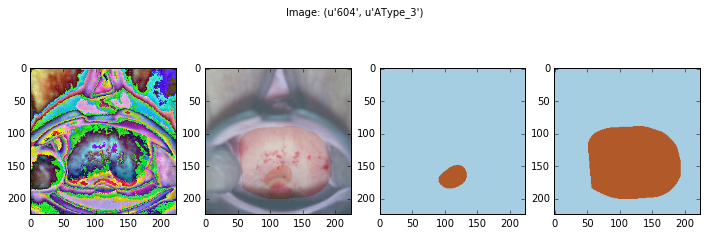

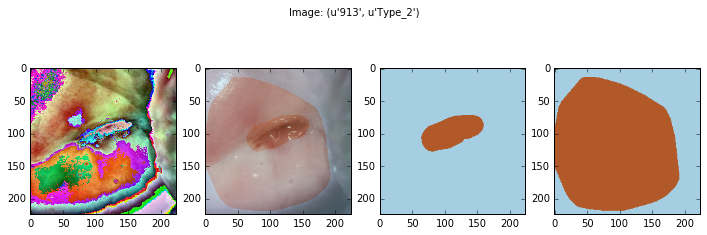

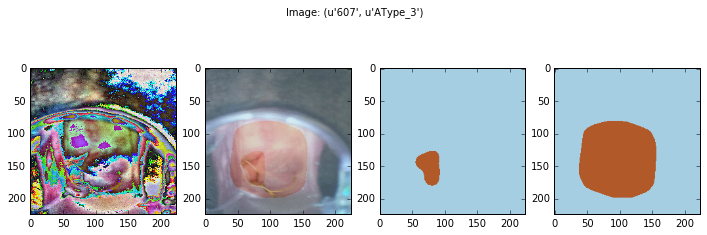

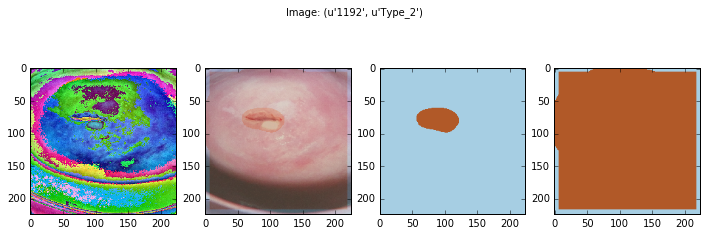

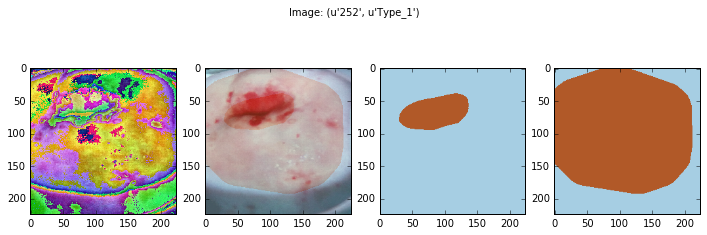

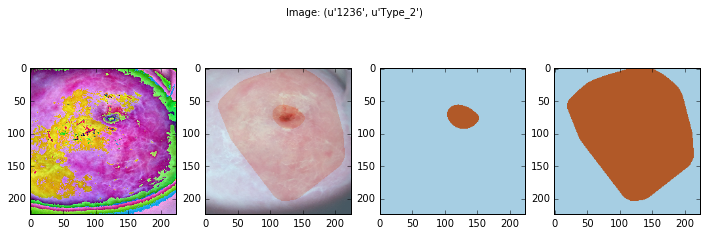

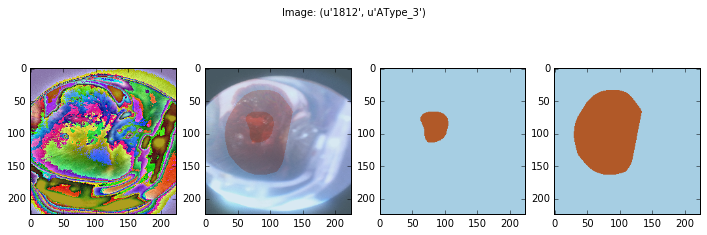

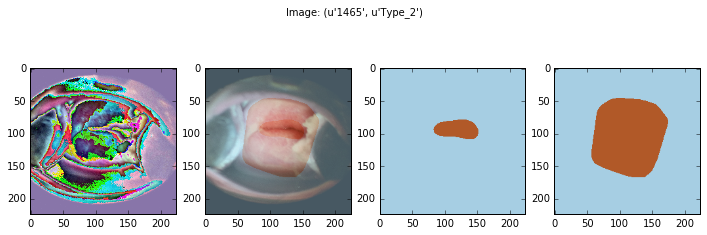

In [27]:
max_counter = 8
n = 2
counter = 0
for x, y_true, info in flow:           
    y_pred = unet.predict(x)    
    print x.shape, y_pred.shape, y_pred.min(), y_pred.max(), info 
    
    y_pred = os_cervix_postproc_batch(y_pred)
    
    if False:
        if counter % n == 0:
            plt_st(12, 4)
        plt.subplot(1, n, counter % n + 1)
        plt.imshow(x[0, :, :, :].transpose([1, 2, 0]))
        plt.imshow(y_pred[0, 0, :, :], alpha=0.25, cmap='Paired') # Os
        plt.imshow(y_pred[0, 1, :, :], alpha=0.25, cmap='Paired') # Cervix
        plt.title("Image: {}".format(info[0]))
        
        
    if True:
        if counter % 1 == 0:
            plt_st(12, 4)
        plt.subplot(1, 4, 1)
        plt.imshow(x[0, :, :, :].transpose([1, 2, 0]))
        plt.subplot(1, 4, 2)        
        plt.imshow(scale_percentile(x[0, :, :, :].transpose([1, 2, 0])))
        plt.imshow(y_pred[0, 0, :, :], alpha=0.25, cmap='Paired') # Os
        plt.imshow(y_pred[0, 1, :, :], alpha=0.25, cmap='Paired') # Cervix
        plt.subplot(1, 4, 3)        
        plt.imshow(y_pred[0, 0, :, :], cmap='Paired') # Os
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred[0, 1, :, :], cmap='Paired') # Cervix
        plt.suptitle("Image: {}".format(info[0]))            
        
    counter += 1
    if counter == max_counter:
        break

### Predictions on validation test

In [28]:
batch_size = 1
flow = gen.flow(xy_provider(val_id_type_list,
                            mask_type='trainval_label_0',
                            test_mode=True,
                            cache=cache,
                            image_size=(224, 224)),
                # Ensure that all batches have the same size
                len(val_id_type_list),
                batch_size=batch_size)

(1, 3, 224, 224) (1, 2, 224, 224) 6.61199e-11 1.0 [(u'8', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 8.21499e-16 1.0 [(u'1172', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 3.41255e-14 1.0 [(u'1075', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 5.19426e-13 1.0 [(u'219', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 3.82331e-16 1.0 [(u'1842', u'AType_3')]
(1, 3, 224, 224) (1, 2, 224, 224) 6.20619e-13 1.0 [(u'1369', u'Type_2')]
(1, 3, 224, 224) (1, 2, 224, 224) 4.16315e-10 1.0 [(u'1414', u'Type_1')]
(1, 3, 224, 224) (1, 2, 224, 224) 2.66476e-17 1.0 [(u'738', u'Type_2')]


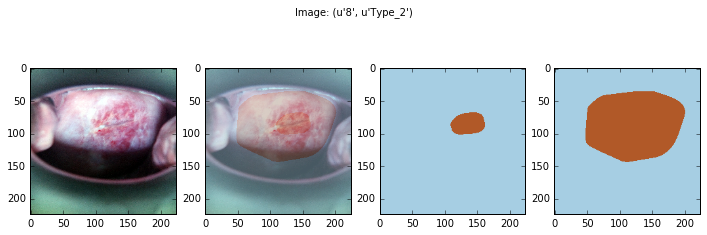

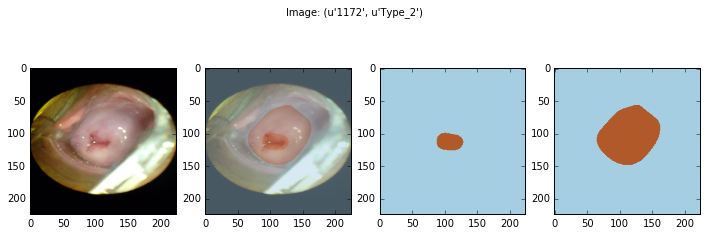

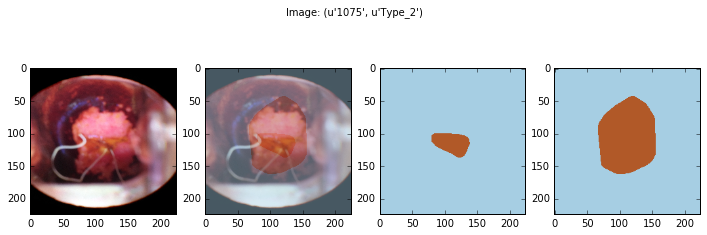

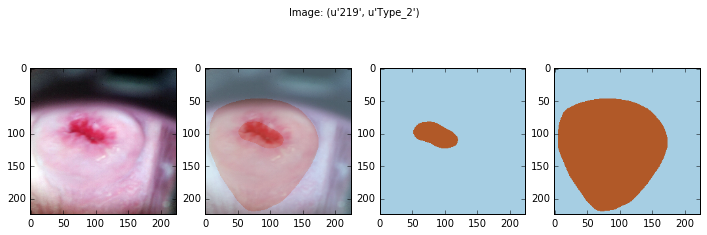

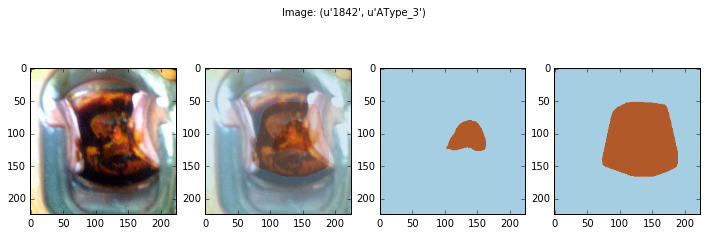

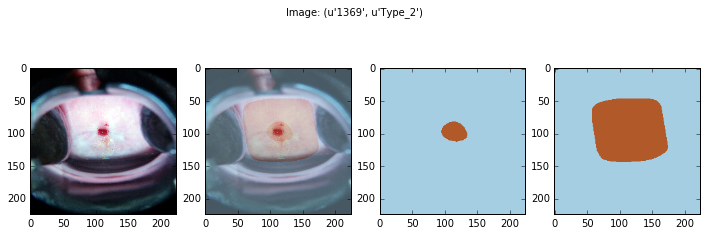

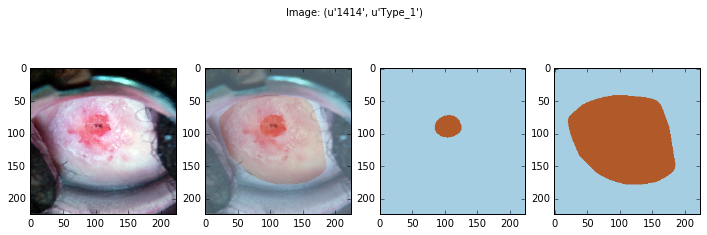

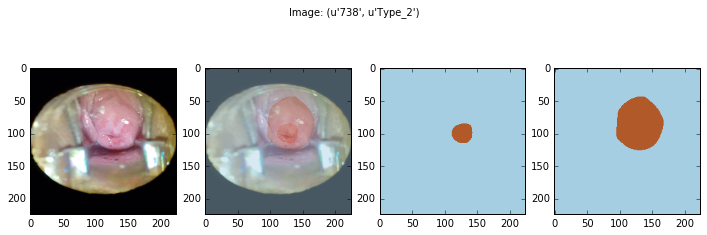

In [33]:
max_counter = 8
n = 2   
counter = 0
for x, y_true, info in flow:           
    y_pred = unet.predict(x)
    print x.shape, y_pred.shape, y_pred.min(), y_pred.max(), info
    
    y_pred = os_cervix_postproc_batch(y_pred)
    
    if False:
        if counter % n == 0:
            plt_st(12, 4)
        plt.subplot(1, n, counter % n + 1)
        plt.imshow(x[0, :, :, :].transpose([1, 2, 0]))
        plt.imshow(y_pred[0, 0, :, :], alpha=0.25, cmap='Paired') # Os
        plt.imshow(y_pred[0, 1, :, :], alpha=0.25, cmap='Paired') # Cervix
        plt.title("Image: {}".format(info[0]))
        
        
    if True:
        if counter % 1 == 0:
            plt_st(12, 4)
        plt.subplot(1, 4, 1)
        plt.imshow(scale_percentile(x[0, :, :, :].transpose([1, 2, 0])))
        plt.subplot(1, 4, 2)        
        plt.imshow(scale_percentile(x[0, :, :, :].transpose([1, 2, 0])))
        plt.imshow(y_pred[0, 0, :, :], alpha=0.25, cmap='Paired') # Os
        plt.imshow(y_pred[0, 1, :, :], alpha=0.25, cmap='Paired') # Cervix
        plt.subplot(1, 4, 3)        
        plt.imshow(y_pred[0, 0, :, :], cmap='Paired') # Os
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred[0, 1, :, :], cmap='Paired') # Cervix
        plt.suptitle("Image: {}".format(info[0]))                      
    counter += 1
    if counter == max_counter:
        break

In [34]:
!ls {GENERATED_DATA}/

cervix_train_stats.npz
check_cervix_stats.npz
check_os_stats.npz
os_cervix_labels_1
os_cervix_labels_2
os_cervix_labels_final
resnet_4_dense_adadelta_seed=2017_stats.npz
resnet_4_dense_cervix_adadelta_seed=2017_stats.npz
resnet_4_dense_cervix_nadam_seed=2017_stats.npz
resnet_4_dense_nadam_seed=2017_stats.npz
resnet_4_dense_seed=2017_stats.npz
resnet_not_trained_original_cervix_adadelta_seed=2017_stats.npz
resnet_not_trained_original_norm_cervix_adadelta_seed=2017_stats.npz
resnet_original_cervix_seed=2017_stats.npz
templates.csv
test
train
trainval_labels_0
unet_os_cervix_detector_opt=adadelta_seed=54321_lr=1.000_a=0.975_stats.npz
unet_os_cervix_detector_seed=2017_lr=0.001_a=0.925_stats.npz
xception_trained_3_dense_norm_cervix_adadelta_seed=2017_stats.npz
xception_trained_3_dense_norm_os_adadelta_seed=2017_stats.npz
xception_trained_norm_os_adadelta_seed=2017_stats.npz
xception_trained_original_cervix_adadelta_seed=2017_stats.npz
xception_trained_original_norm_cervix_adadelta_seed=2017